# plotting quantified data

In [3]:
import xarray as xr

import astropy_xarray
from astropy import units as u

# to be able to read unit attributes following the CF conventions
# import cf_xarray.units  # must be imported before pint_xarray
u.set_enabled_aliases(
    {
        "degK": u.Kelvin,
        "K": u.Kelvin,
        "degrees_north": u.deg,
        "degrees_east": u.deg,
    },
)

xr.set_options(display_expand_data=False)

## load the data

In [4]:
ds = xr.tutorial.open_dataset("air_temperature")
data = ds.air
data

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
[3869000 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 100B 75.0 72.5 70.0 67.5 65.0 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B 200.0 202.5 205.0 207.5 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## quantify the data

<div class="alert alert-info">
<strong>Note:</strong> this example uses the data provided by the <code>xarray.tutorial</code> functions. As such, the <code>units</code> attributes follow the CF conventions, which <code>pint</code> does not understand by default. To still be able to read them we are using the registry provided by <a href="https://github.com/calgray/cf-xarray"><tt>cf-xarray</tt></a>.
</div>

In [5]:
quantified = data.astropy.quantify()
quantified

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)> Size: 31MB
[K] 241.2 242.5 243.5 244.0 244.1 243.9 ... 297.9 297.4 297.2 296.5 296.2 295.7
Coordinates:
  * lat      (lat) float32 100B [°] 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B [°] 200.0 202.5 205.0 ... 325.0 327.5 330.0
  * time     (time) datetime64[ns] 23kB 2013-01-01 ... 2014-12-31T18:00:00
Indexes:
    lat      AstropyIndex(PandasIndex)
    lon      AstropyIndex(PandasIndex)
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## work with the data

In [15]:
monthly_means = (
    quantified.astropy.to("deg_C", equivalencies=u.temperature())
    .sel(time="2013")
    .groupby("time.month")
    .mean()
)
monthly_means

<xarray.DataArray 'air' (month: 12, lat: 25, lon: 53)> Size: 127kB
[°C] -28.68 -28.49 -28.48 -28.67 -28.99 -29.32 ... 24.73 24.77 24.35 24.26 24.22
Coordinates:
  * lat      (lat) float32 100B [°] 75.0 72.5 70.0 67.5 ... 22.5 20.0 17.5 15.0
  * lon      (lon) float32 212B [°] 200.0 202.5 205.0 ... 325.0 327.5 330.0
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Indexes:
    lat      AstropyIndex(PandasIndex)
    lon      AstropyIndex(PandasIndex)
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

Most operations will preserve the units but there are some which will drop them (see the [duck array integration status](https://xarray.pydata.org/en/stable/user-guide/duckarrays.html#missing-features) page). To work around that there are unit-aware versions on the `.pint` accessor. For example, to select data use `.astropy.sel` instead of `.sel`:

In [7]:
monthly_means.sel(
    lat=u.Quantity(4350, "arcmin"),
    lon=u.Quantity(12000, "arcmin"),
)

<xarray.DataArray 'air' (month: 12)> Size: 96B
[K] 247.1 241.9 250.7 257.5 267.7 274.8 276.8 273.6 273.0 269.3 258.6 251.7
Coordinates:
    lat      float32 4B [°] np.float32(72.5)
    lon      float32 4B [°] np.float32(200.0)
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## plot

`xarray`'s plotting functions will cast the data to `numpy.ndarray`, so we need to "dequantify" first.

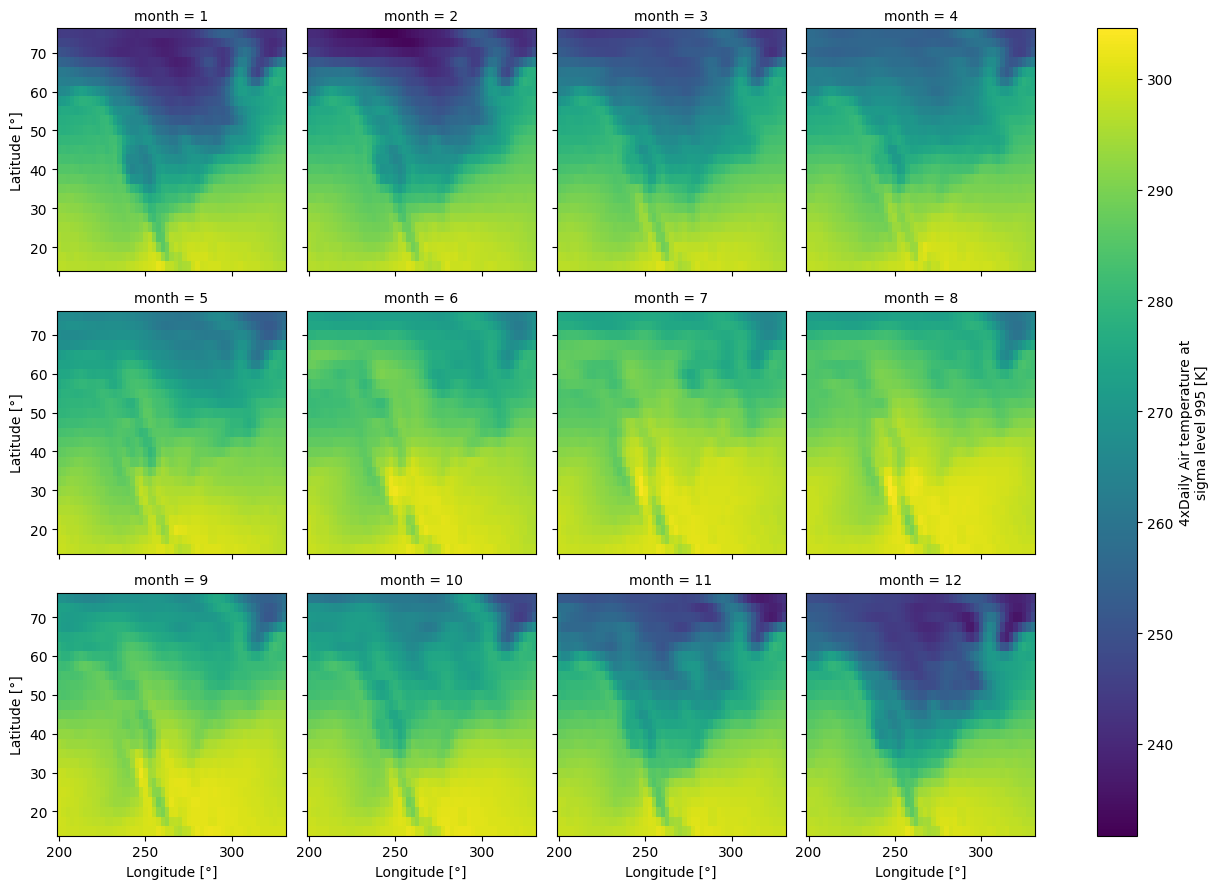

In [8]:
monthly_means.astropy.dequantify(format="unicode").plot.imshow(col="month", col_wrap=4)